# Call Buy Indicator Code

In [6]:
###### Importing all packages #####################################
# optional installations: 
# !pip install yfinance --upgrade --no-cache-dir
# !pip3 install pandas_datareader
# !pip3 install matplotlib


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# ___library_import_statements___
import pandas as pd

# for pandas_datareader, otherwise it might have issues, sometimes there is some version mismatch
pd.core.common.is_list_like = pd.api.types.is_list_like

# make pandas to print dataframes nicely
pd.set_option('expand_frame_repr', False)  

import pandas_datareader.data as web
from pandas_datareader import data as pdr
import numpy as np
import matplotlib.pyplot as plt
import datetime as datetime
import time
import ssl
from urllib import request

#newest yahoo API 
import yfinance as yahoo_finance

#optional 
yahoo_finance.pdr_override()
%matplotlib inline

## Defining Functions

In this section functions for several technical indicators are coded:
1. RSI 
2. Stochastic Slow
3. MACD

In [156]:
def computeRSI(dataframe, time_window):
    
    '''RSI = Relative Strength Index (https://www.investopedia.com/terms/r/rsi.asp)'''
    
    diff = dataframe.diff(1).dropna()        # diff in one field(one day)

    #this preservers dimensions off diff values
    up_chg = 0 * diff
    down_chg = 0 * diff
    
    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[ diff>0 ]
    
    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[ diff < 0 ]
    up_chg_avg   = up_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    down_chg_avg = down_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)

    return rsi


def stochastics(dataframe, low, high, close, k, d):
    """
    Fast stochastic calculation
    %K = (Current Close - Lowest Low)/
    (Highest High - Lowest Low) * 100
    %D = 3-day SMA of %K

    Slow stochastic calculation
    %K = %D of fast stochastic
    %D = 3-day SMA of %K

    When %K crosses above %D, buy signal 
    When the %K crosses below %D, sell signal
    
    https://www.investopedia.com/terms/s/stochasticoscillator.asp
    """

    df = dataframe.copy()

    # Set minimum low and maximum high of the k stoch
    low_min  = df[low].rolling( window = k ).min()
    high_max = df[high].rolling( window = k ).max()

    # Fast Stochastic
    df['k_fast'] = 100 * (df[close] - low_min)/(high_max - low_min)
    df['d_fast'] = df['k_fast'].rolling(window = d).mean()

    # Slow Stochastic
    df['k_slow'] = df["d_fast"]
    df['d_slow'] = df['k_slow'].rolling(window = d).mean()
    df['d_div'] = df['d_fast'] - df['d_slow']

    return df

def MACD(dataframe,close,span1,span2,sig_span):
    
    """
    EMA = exponential moving average
    MACD = Moving Average Convergence Divergence = 12Period EMA - 26Period EMA
    Signal  = 9Period EMA of MACD
    
    https://www.investopedia.com/terms/m/macd.asp
    
    """
    
    df = dataframe.copy()
    exp1 = df[close].ewm(span=span1, adjust=False).mean()
    exp2 = df[close].ewm(span=span2, adjust=False).mean()
    macd = exp1-exp2
    exp3 = macd.ewm(span=sig_span, adjust=False).mean()
    df['MACD line'] = macd
    df['Sig Line'] = exp3
    df['MACD_Div'] = macd-exp3
    return df

def CBI_func(ticker, start_time, end_time, trade_date, holding_days, vol_cutoff, vol_avg_window, 
             RSI_trend_days, RSI_low, RSI_hi, MACD_Div_trend_days, d_slow_trend_days, d_slow_low, d_slow_hi):
    """
    ticker - S&P500 ticker for which stock prices are obtained
    start_time - earliest date at which the stock_price is obtained from yfinance
    end_time - latest date at which the stock price is obtained from yfinance
    trade_date - a date between the start_time and end_time at which a hypothetical trade is entered

    All Technical Indicators are calculated with the "PAST" data and Price changes are calculated with the "FUTURE" data as defined below:
    start_time........................trade_date..........................end_time
    [..............PAST..............]          [...........FUTURE...............]

    CBI [Cumulative Buying Index]:
    - Average of scores calculated from value on trade date, slope and intercept of 'x' days before the trade date of the following Indicators: 
      - Stochastic slow - 14 day average
      - MACD Divergence - standard 12,26,9 day
    - Values closer to zero are strong indicators and the distance from zero defines the strength of the indicator, however, within small intervals 
      distance from zero may not necessarily correlate with strength. For eg: 
        - CBI of 0.1 and 0.5 is highly likely to indicate strong and weak buy respectively
        - CBI of 0.1 and 0.15 may not indicate that the former is a stronger buy than the latter

    """
    
    
    ### DEFINE ALL INPUT VARIABLES
    # holding_days = Number of days in future from the trade date within which change in price of the stock (price_delta) will be calculated
    # vol_avg_window = Number of days in the past over which average traded volume is obtained
    # vol_cutoff = 2e6

    # yahoo gives only daily historical data
    connected = False
    while not connected:
        try:
            ticker_df = web.get_data_yahoo(ticker, start=start_time, end=end_time)
            connected = True;
        except Exception as e:
            print("Ticker: ", ticker,"  >>  Error: " + str(e))
            # time.sleep( 5 )
            continue 
    
    ticker_df = ticker_df.reset_index()
    
    # Get Stock Prices for the ticker between start_time and end_time
    df0 = ticker_df
    # Call functions to calculate the Technical Indicators for each date (row) in the dataframe,...
    # append as columns to the same dataframe                                                                            
    df0['RSI'] = computeRSI(df0['Adj Close'], 14)
    df0 = stochastics( df0, 'Low', 'High', 'Close', 14, 3 )
    df0 = MACD(df0, 'Close', 12, 26, 9)

    # Date to enter a trade
    day0 = trade_date
    
    # Delta trading days between trade_date and end_time
    trade_date_delta = len(df0.index) - df0[df0['Date']==day0].index.values
    
    # Closing price of ticker on trade_date
    trade_date_price = df0['Close'].iloc[-1*trade_date_delta].values    
    

    # Calculate % change in price between trade_date_price and max price in [trade_date+1, trade_date+holding_days]
    day1 = (day0.date() + datetime.timedelta(days = 1)).isoformat()
    day_holding = (day0.date() + datetime.timedelta(days = min(holding_days,trade_date_delta))).isoformat()
    mask = df0['Date'].between(day1, day_holding)
    max_price = df0.loc[mask,'Close'].values.max()
    price_delta = 100.*(max_price - trade_date_price)/trade_date_price
    
    # Extract part of the dataframe from 'start_time' to 'trade_date' into a new dataframe
    df = df0[(df0["Date"] <= day0)]
    #print("Analyzing Ticker: ", ticker, " for trade date: ", day0)

    CBIL = [] #Call Buying Indicator List
    

    avg_volume = avg_volume_in_window(df, vol_avg_window, day0)
    # print("Avg Vol:", avg_volume)
    
    #trade date values
    RSI_val = df[df['Date']==day0]['RSI'].values
    MACD_Div_val = df[df['Date']==day0]['MACD_Div'].values
    d_slow_val = df[df['Date']==day0]['d_slow'].values
    # print("RSI_val:", RSI_val)

    
    #slopes
    RSI_fit = slope_calculator(df, RSI_trend_days, day0, 'RSI') #num_days >=3
    MACD_Div_fit = slope_calculator(df, MACD_Div_trend_days, day0, 'MACD_Div') #num_days >=3
    d_slow_fit = slope_calculator(df, d_slow_trend_days, day0, 'd_slow') #num_days >=3
    # print("Slopes:", RSI_fit,MACD_Div_fit,d_slow_fit)

    # Vol and RSI crieria
    if avg_volume > vol_cutoff and RSI_val > RSI_low and RSI_val < RSI_hi and RSI_fit[0] > 0:
        CBIL.append(day0)
    
        # TECHNICAL INDICATORS ALGEBRA #
        if d_slow_val > d_slow_low and d_slow_val < d_slow_hi and d_slow_fit[0] > 0:
            CBIL.append((abs(d_slow_val - 0.5*(d_slow_hi + d_slow_low))/(0.5*(d_slow_hi - d_slow_low))).item())
        else: 
            CBIL.append(10.0)
    
        if MACD_Div_val < 0 and MACD_Div_fit[1] < 0 and MACD_Div_fit[0] > 0:
            CBIL.append((MACD_Div_val/MACD_Div_fit[1]).item())
        else: 
            CBIL.append(10.0)

      
        CBIL.append(trade_date_price)
        CBIL.append(price_delta)
        CBI = 0.5*(CBIL[1] + CBIL[2])
        CBIL.append(CBI)
      
        if CBI < 0.25:
            print("\nTICKER: ", ticker, "\t","Trade Date: ", day0)
            print("$$$$$ CBI    = ", CBI,"$$$$$")
            print("$$$$$ CBI_SS = ", CBIL[1],"$$$$$")
            print("$$$$$ CBI_MD = ", CBIL[2],"$$$$$")
            print("_________________________________")
            print("RSI             = ", RSI_val," Trend | slope = ", RSI_fit[0], ", intercept = ", RSI_fit[1])
            print("Stochastic Slow = ", d_slow_val, " Trend | slope = ", d_slow_fit[0], ", intercept = ", d_slow_fit[1])
            print("MACD Div        = ", MACD_Div_val, " Trend | slope = ", MACD_Div_fit[0], ", intercept = ", MACD_Div_fit[1])
            print("Average Volume  = ", avg_volume)
            print("_________________________________")
    #else:
        #print("Low Volume or RSI out of bounds")

    print("\n\n")        
    return ticker, CBIL[0], CBIL[1], CBIL[2], CBIL[5], CBIL[3].item(), CBIL[4].item(), avg_volume, RSI_val.item(), RSI_fit, d_slow_val.item(), d_slow_fit, MACD_Div_val.item(), MACD_Div_fit

def avg_volume_in_window(dataframe, num_days, trade_date):
    df = dataframe.copy()
    df['Date'] = pd.to_datetime(df['Date'])

    return df["Volume"].iloc[-1*num_days:-1].mean(axis=0)

def slope_calculator(dataframe, num_days, trade_date,indicator):
    if num_days < 3:
        print("\nError: num_days should be more than or equal to 3\n")
        exit()

    df = dataframe.copy()
    df['Date'] = pd.to_datetime(df['Date'])
  
    Y = np.array(df[indicator].iloc[-1*num_days:-1])
    X = np.array([n for n in range(0, len(Y))])
    Z = np.polyfit(X,Y,1)
    return Z
  

## Main Code

In this section, a single ticker is analyzed for a range of dates

In [157]:
start_time = '2020-11-14'
end_time = '2021-04-01'
print("Start Date: ", start_time)
print("End Date: ", end_time )

ticker_list = ['DD']
trade_days_min = '2021-02-26'
trade_days_max = '2021-02-26'
test_days = pd.bdate_range(trade_days_min, trade_days_max)

#print(test_days)
#CBI_all = []

for ticker in ticker_list: 
    for days in test_days:
        output = CBI_func(ticker, start_time, end_time, days, holding_days = 15, vol_cutoff = 2.0e6, 
                          vol_avg_window = 7, RSI_trend_days = 7, RSI_low = 40., RSI_hi = 75., MACD_Div_trend_days = 4, 
                          d_slow_trend_days = 4, d_slow_low = 10., d_slow_hi = 50.)
        if len(output) > 0:
            print(*output)

Start Date:  2020-11-14
End Date:  2021-04-01
[*********************100%***********************]  1 of 1 completed

TICKER:  DD 	 Trade Date:  2021-02-26 00:00:00
$$$$$ CBI    =  0.17992920853066846 $$$$$
$$$$$ CBI_SS =  0.04766694383955894 $$$$$
$$$$$ CBI_MD =  0.312191473221778 $$$$$
_________________________________
RSI             =  [44.19380586]  Trend | slope =  1.353252155749618 , intercept =  36.24339071038467
Stochastic Slow =  [29.04666112]  Trend | slope =  5.438461186182725 , intercept =  12.107048060837794
MACD Div        =  [-0.22058355]  Trend | slope =  0.1948279780497742 , intercept =  -0.7065649502140348
Average Volume  =  7232666.666666667
_________________________________



DD 2021-02-26 00:00:00 0.04766694383955894 0.312191473221778 0.17992920853066846 70.31999969482422 9.584752407593678 7232666.666666667 44.193805860967224 [ 1.35325216 36.24339071] 29.04666112320882 [ 5.43846119 12.10704806] -0.22058355273419172 [ 0.19482798 -0.70656495]


In [158]:
column_names = ['Symbol', 'Trade_Date','CBI_SS','CBI_MACD','CBI','Trade_Price','Price_Delta', 
                'Avg_Volume', 'RSI_val', 'RSI_slope, intercept', 'SS_val', 'SS_slope, intercept', 
                'MSCD_Div_val', 'MACD_Div_slope, intercept']

#passed = pd.DataFrame()
passed = pd.DataFrame([output], columns=column_names)
passed.head()

,Symbol,Trade_Date,CBI_SS,CBI_MACD,CBI,Trade_Price,Price_Delta,Avg_Volume,RSI_val,"RSI_slope, intercept",SS_val,"SS_slope, intercept",MSCD_Div_val,"MACD_Div_slope, intercept"
0,DD,2021-02-26,0.047667,0.312191,0.179929,70.32,9.584752,7.232667e+06,44.193806,"[1.353252155749618, 36.24339071038467]",29.046661,"[5.438461186182725, 12.107048060837794]",-0.220584,"[0.1948279780497742, -0.7065649502140348]"


In [65]:

url="https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
##START - only needed when  getting SSLVerificationError in local##
context = ssl._create_unverified_context()
response = request.urlopen(url, context=context)
html = response.read()
##END - only needed when  getting SSLVerificationError in local##
table=pd.read_html(html)
sp500 = table[0]
sp500 = sp500[['Symbol','Security','GICS Sector']]
sector_list = list(sp500['GICS Sector'].unique())
print(sector_list)
sp500.head(5)

['Industrials', 'Health Care', 'Information Technology', 'Communication Services', 'Consumer Discretionary', 'Utilities', 'Financials', 'Materials', 'Real Estate', 'Consumer Staples', 'Energy']


,Symbol,Security,GICS Sector
0,MMM,3M Company,Industrials
1,ABT,Abbott Laboratories,Health Care
2,ABBV,AbbVie Inc.,Health Care
3,ABMD,Abiomed,Health Care
4,ACN,Accenture,Information Technology


In [131]:
# initializing dataframe
#sp500['Trade_Date'] = np.nan
#sp500['CBI_SS']= np.nan
#sp500['CBI_MACD']= np.nan
#sp500['Trade_Price $'] = np.nan
#sp500['Price_Delta %'] = np.nan
#sp500['CBI'] = np.nan


# dropping tickers with . like BRK.B
sp500 = sp500[sp500['Symbol'] != "."]

# intializing dataframe
column_names = ['Symbol', 'Trade_Date','CBI_SS','CBI_MACD','CBI','Trade_Price','Price_Delta', 
                'Avg_Volume', 'RSI_val', 'RSI_slope, intercept', 'SS_val', 'SS_slope, intercept', 
                'MSCD_Div_val', 'MACD_Div_slope, intercept']

passed_trades = pd.DataFrame()



#passed_tickers=[]
no_data_tickers = []

# start_time and end_time to fetch data from yahoo
start_time = '2020-11-14'
end_time = '2021-04-01'

# start and end dates of trading period
trade_days_start = '2021-01-15'
trade_days_end = '2021-03-01'
test_days = pd.bdate_range(trade_days_start, trade_days_end)

sector_test = ['Energy']
#ticker_list = ['DD']

for sector in sector_test:
    ticker_list = list(sp500[sp500['GICS Sector']==sector]['Symbol'])
    for ticker in ticker_list:
        for days in test_days:
            try:
                output = CBI_func(ticker, start_time, end_time, days, holding_days = 15, vol_cutoff = 2.0e6, 
                                  vol_avg_window = 7, RSI_trend_days = 7, RSI_low = 40., RSI_hi = 75., MACD_Div_trend_days = 4, 
                                  d_slow_trend_days = 4, d_slow_low = 10., d_slow_hi = 50.)
                
                if len(output) > 0 and output[4] < 1.0:
                    passed = pd.DataFrame([output], columns=column_names)
                    passed_trades = passed_trades.append(passed, ignore_index = True)
                
            except Exception as e:
                print('Analyzed Security: ',ticker, 'No Data')
                print("Ticker: ", ticker,"  >>  Error: " + str(e))
                no_data_tickers.append(ticker)
                #traceback.print_exc()
                continue


#print("CBI = ", CBI_all)
#print(sp500)
#print('Tickers Qualified by CBI Criteria: ', passed_tickers)
#print('Tickers for which data was not obtained: ', no_data_tickers)
#passed_trades.plot(x='CBI',y='Price_Delta',style='o')

[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



Analyzed Security:  APA No Data
Ticker:  APA   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  APA No Data
Ticker:  APA   >>  Error: list index out of range


<ipython-input-114-4d8d5a5bee19>:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  day_holding = (day0.date() + datetime.timedelta(days = min(holding_days,trade_date_delta))).isoformat()
<ipython-input-114-4d8d5a5bee19>:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if avg_volume > vol_cutoff and RSI_val > RSI_low and RSI_val < RSI_hi and RSI_fit[0] > 0:


[*********************100%***********************]  1 of 1 completed



Analyzed Security:  APA No Data
Ticker:  APA   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  APA No Data
Ticker:  APA   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  APA No Data
Ticker:  APA   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  APA No Data
Ticker:  APA   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  APA No Data
Ticker:  APA   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  APA No Data
Ticker:  APA   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Anal

<ipython-input-114-4d8d5a5bee19>:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  day_holding = (day0.date() + datetime.timedelta(days = min(holding_days,trade_date_delta))).isoformat()
<ipython-input-114-4d8d5a5bee19>:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if avg_volume > vol_cutoff and RSI_val > RSI_low and RSI_val < RSI_hi and RSI_fit[0] > 0:






[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



Analyzed Security:  BKR No Data
Ticker:  BKR   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed


<ipython-input-114-4d8d5a5bee19>:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  day_holding = (day0.date() + datetime.timedelta(days = min(holding_days,trade_date_delta))).isoformat()
<ipython-input-114-4d8d5a5bee19>:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if avg_volume > vol_cutoff and RSI_val > RSI_low and RSI_val < RSI_hi and RSI_fit[0] > 0:





[*********************100%***********************]  1 of 1 completed



Analyzed Security:  BKR No Data
Ticker:  BKR   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  BKR No Data
Ticker:  BKR   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  BKR No Data
Ticker:  BKR   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  BKR No Data
Ticker:  BKR   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  BKR No Data
Ticker:  BKR   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  BKR No Data
Ticker:  BKR   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



A

<ipython-input-114-4d8d5a5bee19>:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  day_holding = (day0.date() + datetime.timedelta(days = min(holding_days,trade_date_delta))).isoformat()
<ipython-input-114-4d8d5a5bee19>:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if avg_volume > vol_cutoff and RSI_val > RSI_low and RSI_val < RSI_hi and RSI_fit[0] > 0:


[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



Analyzed Security:  COG No Data
Ticker:  COG   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed





<ipython-input-114-4d8d5a5bee19>:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  day_holding = (day0.date() + datetime.timedelta(days = min(holding_days,trade_date_delta))).isoformat()
<ipython-input-114-4d8d5a5bee19>:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if avg_volume > vol_cutoff and RSI_val > RSI_low and RSI_val < RSI_hi and RSI_fit[0] > 0:


[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



Analyzed Security:  COG No Data
Ticker:  COG   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  COG No Data
Ticker:  COG   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  COG No Data
Ticker:  COG   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  COG No Data
Ticker:  COG   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  COG No Data
Ticker:  COG   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



Analyzed Secur

<ipython-input-114-4d8d5a5bee19>:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  day_holding = (day0.date() + datetime.timedelta(days = min(holding_days,trade_date_delta))).isoformat()
<ipython-input-114-4d8d5a5bee19>:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if avg_volume > vol_cutoff and RSI_val > RSI_low and RSI_val < RSI_hi and RSI_fit[0] > 0:


[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



Analyzed Security:  COG No Data
Ticker:  COG   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  COG No Data
Ticker:  COG   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



Analyzed Security:  CVX No Data
Ticker:  CVX

<ipython-input-114-4d8d5a5bee19>:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  day_holding = (day0.date() + datetime.timedelta(days = min(holding_days,trade_date_delta))).isoformat()
<ipython-input-114-4d8d5a5bee19>:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if avg_volume > vol_cutoff and RSI_val > RSI_low and RSI_val < RSI_hi and RSI_fit[0] > 0:


[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



Analyzed Security:  CVX No Data
Ticker:  CVX   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  CVX No Data
Ticker:  CVX   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  CVX No Data
Ticker:  CVX   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  CVX No Data
Ticker:  CVX   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  CVX No Data
Ticker:  CVX   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  CVX No Data
Ticker:  CVX   >>  Error: list index out of range
[***

<ipython-input-114-4d8d5a5bee19>:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  day_holding = (day0.date() + datetime.timedelta(days = min(holding_days,trade_date_delta))).isoformat()
<ipython-input-114-4d8d5a5bee19>:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if avg_volume > vol_cutoff and RSI_val > RSI_low and RSI_val < RSI_hi and RSI_fit[0] > 0:






[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



Analyzed Security:  CVX No Data
Ticker:  CVX   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



Analyzed Security:  COP No Data
Ticker:  COP   >>  Error: list index out of range
[*********************100%**************

<ipython-input-114-4d8d5a5bee19>:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  day_holding = (day0.date() + datetime.timedelta(days = min(holding_days,trade_date_delta))).isoformat()
<ipython-input-114-4d8d5a5bee19>:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if avg_volume > vol_cutoff and RSI_val > RSI_low and RSI_val < RSI_hi and RSI_fit[0] > 0:


[*********************100%***********************]  1 of 1 completed



Analyzed Security:  COP No Data
Ticker:  COP   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  COP No Data
Ticker:  COP   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  COP No Data
Ticker:  COP   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  COP No Data
Ticker:  COP   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  COP No Data
Ticker:  COP   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  COP No Data
Ticker:  COP   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Anal

<ipython-input-114-4d8d5a5bee19>:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  day_holding = (day0.date() + datetime.timedelta(days = min(holding_days,trade_date_delta))).isoformat()
<ipython-input-114-4d8d5a5bee19>:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if avg_volume > vol_cutoff and RSI_val > RSI_low and RSI_val < RSI_hi and RSI_fit[0] > 0:





[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



Analyzed Security:  COP No Data
Ticker:  COP   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  COP No Data
Ticker:  COP   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  COP No Data
Ticker:  COP   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%*****

<ipython-input-114-4d8d5a5bee19>:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  day_holding = (day0.date() + datetime.timedelta(days = min(holding_days,trade_date_delta))).isoformat()
<ipython-input-114-4d8d5a5bee19>:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if avg_volume > vol_cutoff and RSI_val > RSI_low and RSI_val < RSI_hi and RSI_fit[0] > 0:





[*********************100%***********************]  1 of 1 completed



Analyzed Security:  DVN No Data
Ticker:  DVN   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  DVN No Data
Ticker:  DVN   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  DVN No Data
Ticker:  DVN   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  DVN No Data
Ticker:  DVN   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  DVN No Data
Ticker:  DVN   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  DVN No Data
Ticker:  DVN   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



A

<ipython-input-114-4d8d5a5bee19>:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  day_holding = (day0.date() + datetime.timedelta(days = min(holding_days,trade_date_delta))).isoformat()
<ipython-input-114-4d8d5a5bee19>:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if avg_volume > vol_cutoff and RSI_val > RSI_low and RSI_val < RSI_hi and RSI_fit[0] > 0:


[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



Analyzed Security:  DVN No Data
Ticker:  DVN   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  DVN No Data
Ticker:  DVN   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



Analyzed Security:  DVN No Data
Ticker:  DVN   >>  Error: list index out of range
[*********************100%********

<ipython-input-114-4d8d5a5bee19>:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  day_holding = (day0.date() + datetime.timedelta(days = min(holding_days,trade_date_delta))).isoformat()
<ipython-input-114-4d8d5a5bee19>:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if avg_volume > vol_cutoff and RSI_val > RSI_low and RSI_val < RSI_hi and RSI_fit[0] > 0:


[*********************100%***********************]  1 of 1 completed



Analyzed Security:  FANG No Data
Ticker:  FANG   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  FANG No Data
Ticker:  FANG   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  FANG No Data
Ticker:  FANG   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  FANG No Data
Ticker:  FANG   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



Analyzed Security:  FANG No Data
Ticker:  FANG   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  FANG No Data
Ticker:  FANG   >>  Error: list index out o

<ipython-input-114-4d8d5a5bee19>:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  day_holding = (day0.date() + datetime.timedelta(days = min(holding_days,trade_date_delta))).isoformat()
<ipython-input-114-4d8d5a5bee19>:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if avg_volume > vol_cutoff and RSI_val > RSI_low and RSI_val < RSI_hi and RSI_fit[0] > 0:


[*********************100%***********************]  1 of 1 completed



Analyzed Security:  FANG No Data
Ticker:  FANG   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



Analyzed Security:  FANG No Data
Ticker:  FANG   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  FANG No Data
Ticker:  FANG   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  FANG No Data
Ticker:  FANG   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  FANG No Data
Ticker:  FANG   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[***

<ipython-input-114-4d8d5a5bee19>:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  day_holding = (day0.date() + datetime.timedelta(days = min(holding_days,trade_date_delta))).isoformat()
<ipython-input-114-4d8d5a5bee19>:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if avg_volume > vol_cutoff and RSI_val > RSI_low and RSI_val < RSI_hi and RSI_fit[0] > 0:


[*********************100%***********************]  1 of 1 completed



Analyzed Security:  EOG No Data
Ticker:  EOG   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  EOG No Data
Ticker:  EOG   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  EOG No Data
Ticker:  EOG   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  EOG No Data
Ticker:  EOG   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  EOG No Data
Ticker:  EOG   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  EOG No Data
Ticker:  EOG   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Anal

<ipython-input-114-4d8d5a5bee19>:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  day_holding = (day0.date() + datetime.timedelta(days = min(holding_days,trade_date_delta))).isoformat()
<ipython-input-114-4d8d5a5bee19>:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if avg_volume > vol_cutoff and RSI_val > RSI_low and RSI_val < RSI_hi and RSI_fit[0] > 0:






[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



Analyzed Security:  EOG No Data
Ticker:  EOG   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



Analyzed Security:  EOG No Data
Ticker:  EOG   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



Analyzed Security:  XOM No Data
Ticker: 

<ipython-input-114-4d8d5a5bee19>:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  day_holding = (day0.date() + datetime.timedelta(days = min(holding_days,trade_date_delta))).isoformat()
<ipython-input-114-4d8d5a5bee19>:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if avg_volume > vol_cutoff and RSI_val > RSI_low and RSI_val < RSI_hi and RSI_fit[0] > 0:


[*********************100%***********************]  1 of 1 completed



Analyzed Security:  XOM No Data
Ticker:  XOM   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  XOM No Data
Ticker:  XOM   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  XOM No Data
Ticker:  XOM   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  XOM No Data
Ticker:  XOM   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  XOM No Data
Ticker:  XOM   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  XOM No Data
Ticker:  XOM   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Anal

<ipython-input-114-4d8d5a5bee19>:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  day_holding = (day0.date() + datetime.timedelta(days = min(holding_days,trade_date_delta))).isoformat()
<ipython-input-114-4d8d5a5bee19>:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if avg_volume > vol_cutoff and RSI_val > RSI_low and RSI_val < RSI_hi and RSI_fit[0] > 0:






Analyzed Security:  XOM No Data
Ticker:  XOM   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  XOM No Data
Ticker:  XOM   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



Analyzed Security:  XOM No Data
Ticker:  XOM   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



Analyzed Security:  XOM No Data
Ticker:  XOM   >>  Error: list index out of range
[*******************

<ipython-input-114-4d8d5a5bee19>:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  day_holding = (day0.date() + datetime.timedelta(days = min(holding_days,trade_date_delta))).isoformat()
<ipython-input-114-4d8d5a5bee19>:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if avg_volume > vol_cutoff and RSI_val > RSI_low and RSI_val < RSI_hi and RSI_fit[0] > 0:






Analyzed Security:  HAL No Data
Ticker:  HAL   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  HAL No Data
Ticker:  HAL   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  HAL No Data
Ticker:  HAL   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  HAL No Data
Ticker:  HAL   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  HAL No Data
Ticker:  HAL   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  HAL No Data
Ticker:  HAL   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  HAL No Data
Ticker:  HAL   >>  Error: list index out

<ipython-input-114-4d8d5a5bee19>:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  day_holding = (day0.date() + datetime.timedelta(days = min(holding_days,trade_date_delta))).isoformat()
<ipython-input-114-4d8d5a5bee19>:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if avg_volume > vol_cutoff and RSI_val > RSI_low and RSI_val < RSI_hi and RSI_fit[0] > 0:


[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



Analyzed Security:  HAL No Data
Ticker:  HAL   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  HAL No Data
Ticker:  HAL   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



Analyzed Security:  HES No Data
Ticker:  HES   >>  Error: list index out of range
[*********************100%********

<ipython-input-114-4d8d5a5bee19>:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  day_holding = (day0.date() + datetime.timedelta(days = min(holding_days,trade_date_delta))).isoformat()


[*********************100%***********************]  1 of 1 completed



Analyzed Security:  HES No Data
Ticker:  HES   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  HES No Data
Ticker:  HES   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  HES No Data
Ticker:  HES   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  HES No Data
Ticker:  HES   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  HES No Data
Ticker:  HES   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  HES No Data
Ticker:  HES   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Anal

<ipython-input-114-4d8d5a5bee19>:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  day_holding = (day0.date() + datetime.timedelta(days = min(holding_days,trade_date_delta))).isoformat()
<ipython-input-114-4d8d5a5bee19>:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if avg_volume > vol_cutoff and RSI_val > RSI_low and RSI_val < RSI_hi and RSI_fit[0] > 0:


[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



Analyzed Security:  HES No Data
Ticker:  HES   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



Analyzed Security:  HFC No Data
Ticker:  HFC   >>  Error: list index out of range


<ipython-input-114-4d8d5a5bee19>:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  day_holding = (day0.date() + datetime.timedelta(days = min(holding_days,trade_date_delta))).isoformat()
<ipython-input-114-4d8d5a5bee19>:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if avg_volume > vol_cutoff and RSI_val > RSI_low and RSI_val < RSI_hi and RSI_fit[0] > 0:


[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



Analyzed Security:  HFC No Data
Ticker:  HFC   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



Analyzed Security:  HFC No Data
Ticker:  HFC   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  HFC No Data
Ticker:  HFC

<ipython-input-114-4d8d5a5bee19>:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  day_holding = (day0.date() + datetime.timedelta(days = min(holding_days,trade_date_delta))).isoformat()


[*********************100%***********************]  1 of 1 completed



Analyzed Security:  HFC No Data
Ticker:  HFC   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  HFC No Data
Ticker:  HFC   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  HFC No Data
Ticker:  HFC   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  HFC No Data
Ticker:  HFC   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  HFC No Data
Ticker:  HFC   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  HFC No Data
Ticker:  HFC   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Anal

<ipython-input-114-4d8d5a5bee19>:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  day_holding = (day0.date() + datetime.timedelta(days = min(holding_days,trade_date_delta))).isoformat()
<ipython-input-114-4d8d5a5bee19>:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if avg_volume > vol_cutoff and RSI_val > RSI_low and RSI_val < RSI_hi and RSI_fit[0] > 0:


[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



Analyzed Security:  KMI No Data
Ticker:  KMI   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  KMI No Data
Ticker:  KMI   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  KMI No Data
Ticker:  KMI   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  KMI No Data
Ticker:  KMI   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  KMI No Data
Ticker:  KMI   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Secur

<ipython-input-114-4d8d5a5bee19>:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  day_holding = (day0.date() + datetime.timedelta(days = min(holding_days,trade_date_delta))).isoformat()
<ipython-input-114-4d8d5a5bee19>:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if avg_volume > vol_cutoff and RSI_val > RSI_low and RSI_val < RSI_hi and RSI_fit[0] > 0:


[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



Analyzed Security:  KMI No Data
Ticker:  KMI   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



Analyzed Security:  KMI No Data
Ticker:  KMI   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



[*********************100%******************

<ipython-input-114-4d8d5a5bee19>:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  day_holding = (day0.date() + datetime.timedelta(days = min(holding_days,trade_date_delta))).isoformat()
<ipython-input-114-4d8d5a5bee19>:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if avg_volume > vol_cutoff and RSI_val > RSI_low and RSI_val < RSI_hi and RSI_fit[0] > 0:


[*********************100%***********************]  1 of 1 completed



Analyzed Security:  MRO No Data
Ticker:  MRO   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  MRO No Data
Ticker:  MRO   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  MRO No Data
Ticker:  MRO   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  MRO No Data
Ticker:  MRO   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  MRO No Data
Ticker:  MRO   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  MRO No Data
Ticker:  MRO   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Anal

<ipython-input-114-4d8d5a5bee19>:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  day_holding = (day0.date() + datetime.timedelta(days = min(holding_days,trade_date_delta))).isoformat()
<ipython-input-114-4d8d5a5bee19>:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if avg_volume > vol_cutoff and RSI_val > RSI_low and RSI_val < RSI_hi and RSI_fit[0] > 0:


[*********************100%***********************]  1 of 1 completed



Analyzed Security:  MRO No Data
Ticker:  MRO   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



Analyzed Security:  MRO No Data
Ticker:  MRO   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



Analyzed Security:  MRO No Data
Ticker:  MRO   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  MRO No Data
Ticker:  MRO   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************10

<ipython-input-114-4d8d5a5bee19>:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  day_holding = (day0.date() + datetime.timedelta(days = min(holding_days,trade_date_delta))).isoformat()
<ipython-input-114-4d8d5a5bee19>:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if avg_volume > vol_cutoff and RSI_val > RSI_low and RSI_val < RSI_hi and RSI_fit[0] > 0:






Analyzed Security:  MPC No Data
Ticker:  MPC   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  MPC No Data
Ticker:  MPC   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  MPC No Data
Ticker:  MPC   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



Analyzed Security:  MPC No Data
Ticker:  MPC   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



Analyzed Security:  MPC No Data
Ticker:  MPC   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  MPC No Data
Ticker:  MPC   >>  Error: list index out of range


<ipython-input-114-4d8d5a5bee19>:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  day_holding = (day0.date() + datetime.timedelta(days = min(holding_days,trade_date_delta))).isoformat()
<ipython-input-114-4d8d5a5bee19>:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if avg_volume > vol_cutoff and RSI_val > RSI_low and RSI_val < RSI_hi and RSI_fit[0] > 0:


[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



Analyzed Security:  MPC No Data
Ticker:  MPC   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  MPC No Data
Ticker:  MPC   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  MPC No Data
Ticker:  MPC   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



Analyzed Security:  MPC No Data
Ti

<ipython-input-114-4d8d5a5bee19>:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  day_holding = (day0.date() + datetime.timedelta(days = min(holding_days,trade_date_delta))).isoformat()
<ipython-input-114-4d8d5a5bee19>:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if avg_volume > vol_cutoff and RSI_val > RSI_low and RSI_val < RSI_hi and RSI_fit[0] > 0:


[*********************100%***********************]  1 of 1 completed



Analyzed Security:  NOV No Data
Ticker:  NOV   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  NOV No Data
Ticker:  NOV   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  NOV No Data
Ticker:  NOV   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  NOV No Data
Ticker:  NOV   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  NOV No Data
Ticker:  NOV   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  NOV No Data
Ticker:  NOV   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Anal

<ipython-input-114-4d8d5a5bee19>:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  day_holding = (day0.date() + datetime.timedelta(days = min(holding_days,trade_date_delta))).isoformat()
<ipython-input-114-4d8d5a5bee19>:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if avg_volume > vol_cutoff and RSI_val > RSI_low and RSI_val < RSI_hi and RSI_fit[0] > 0:


[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



Analyzed Security:  NOV No Data
Ticker:  NOV   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



Analyzed Security:  OXY No Data
Ticker:  OXY   >>  Err

<ipython-input-114-4d8d5a5bee19>:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  day_holding = (day0.date() + datetime.timedelta(days = min(holding_days,trade_date_delta))).isoformat()
<ipython-input-114-4d8d5a5bee19>:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if avg_volume > vol_cutoff and RSI_val > RSI_low and RSI_val < RSI_hi and RSI_fit[0] > 0:


[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



Analyzed Security:  OXY No Data
Ticker:  OXY   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  OXY No Data
Ticker:  OXY   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  OXY No Data
Ticker:  OXY   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  OXY No Data
Ticker:  OXY   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  OXY No Data
Ticker:  OXY   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  OXY No Data
Ticker:  OXY   >>  Error: list index out of range
[***

<ipython-input-114-4d8d5a5bee19>:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  day_holding = (day0.date() + datetime.timedelta(days = min(holding_days,trade_date_delta))).isoformat()
<ipython-input-114-4d8d5a5bee19>:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if avg_volume > vol_cutoff and RSI_val > RSI_low and RSI_val < RSI_hi and RSI_fit[0] > 0:


[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



Analyzed Security:  OXY No Data
Ticker:  OXY   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



Analyzed Security:  OXY No Data
Ticker:  OXY   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  OXY No Data
Ticker:  OXY   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  OXY No Data
Ticker:  OXY   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  OXY No Data
Ticker:  OXY   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



[*************

<ipython-input-114-4d8d5a5bee19>:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  day_holding = (day0.date() + datetime.timedelta(days = min(holding_days,trade_date_delta))).isoformat()
<ipython-input-114-4d8d5a5bee19>:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if avg_volume > vol_cutoff and RSI_val > RSI_low and RSI_val < RSI_hi and RSI_fit[0] > 0:


[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



Analyzed Security:  OKE No Data
Ticker:  OKE   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  OKE No Data
Ticker:  OKE   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  OKE No Data
Ticker:  OKE   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  OKE No Data
Ticker:  OKE   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  OKE No Data
Ticker:  OKE   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Secur

<ipython-input-114-4d8d5a5bee19>:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  day_holding = (day0.date() + datetime.timedelta(days = min(holding_days,trade_date_delta))).isoformat()
<ipython-input-114-4d8d5a5bee19>:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if avg_volume > vol_cutoff and RSI_val > RSI_low and RSI_val < RSI_hi and RSI_fit[0] > 0:


[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



Analyzed Security:  OKE No Data
Ticker:  OKE   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  OKE No Data
Ticker:  OKE   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  OKE No Data
Ticker:  OKE   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  OKE No Data
Ticker:  OKE   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  OKE No Data
Ticker:  OKE   >>  Error: list index out of range
[*************

<ipython-input-114-4d8d5a5bee19>:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  day_holding = (day0.date() + datetime.timedelta(days = min(holding_days,trade_date_delta))).isoformat()
<ipython-input-114-4d8d5a5bee19>:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if avg_volume > vol_cutoff and RSI_val > RSI_low and RSI_val < RSI_hi and RSI_fit[0] > 0:


[*********************100%***********************]  1 of 1 completed



Analyzed Security:  PSX No Data
Ticker:  PSX   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  PSX No Data
Ticker:  PSX   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  PSX No Data
Ticker:  PSX   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  PSX No Data
Ticker:  PSX   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  PSX No Data
Ticker:  PSX   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  PSX No Data
Ticker:  PSX   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Anal

<ipython-input-114-4d8d5a5bee19>:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  day_holding = (day0.date() + datetime.timedelta(days = min(holding_days,trade_date_delta))).isoformat()
<ipython-input-114-4d8d5a5bee19>:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if avg_volume > vol_cutoff and RSI_val > RSI_low and RSI_val < RSI_hi and RSI_fit[0] > 0:


[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



Analyzed Security:  PSX No Data
Ticker:  PSX   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  PSX No Data
Ticker:  PSX   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  PSX No Data
Ticker:  PSX   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



Analyzed Security:  PSX No Data
Ticker:  PSX   >>  Error: list index out of range
[*********************10

<ipython-input-114-4d8d5a5bee19>:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  day_holding = (day0.date() + datetime.timedelta(days = min(holding_days,trade_date_delta))).isoformat()
<ipython-input-114-4d8d5a5bee19>:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if avg_volume > vol_cutoff and RSI_val > RSI_low and RSI_val < RSI_hi and RSI_fit[0] > 0:


[*********************100%***********************]  1 of 1 completed



Analyzed Security:  PXD No Data
Ticker:  PXD   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  PXD No Data
Ticker:  PXD   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  PXD No Data
Ticker:  PXD   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  PXD No Data
Ticker:  PXD   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  PXD No Data
Ticker:  PXD   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  PXD No Data
Ticker:  PXD   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Anal

<ipython-input-114-4d8d5a5bee19>:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  day_holding = (day0.date() + datetime.timedelta(days = min(holding_days,trade_date_delta))).isoformat()
<ipython-input-114-4d8d5a5bee19>:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if avg_volume > vol_cutoff and RSI_val > RSI_low and RSI_val < RSI_hi and RSI_fit[0] > 0:


[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



Analyzed Security:  SLB No Data
Ticker:  SLB   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  SLB No Data
Ticker:  SLB   >>  Error: list index out of range


<ipython-input-114-4d8d5a5bee19>:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  day_holding = (day0.date() + datetime.timedelta(days = min(holding_days,trade_date_delta))).isoformat()
<ipython-input-114-4d8d5a5bee19>:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if avg_volume > vol_cutoff and RSI_val > RSI_low and RSI_val < RSI_hi and RSI_fit[0] > 0:


[*********************100%***********************]  1 of 1 completed



Analyzed Security:  SLB No Data
Ticker:  SLB   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  SLB No Data
Ticker:  SLB   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  SLB No Data
Ticker:  SLB   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  SLB No Data
Ticker:  SLB   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  SLB No Data
Ticker:  SLB   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  SLB No Data
Ticker:  SLB   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Anal

<ipython-input-114-4d8d5a5bee19>:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  day_holding = (day0.date() + datetime.timedelta(days = min(holding_days,trade_date_delta))).isoformat()
<ipython-input-114-4d8d5a5bee19>:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if avg_volume > vol_cutoff and RSI_val > RSI_low and RSI_val < RSI_hi and RSI_fit[0] > 0:


[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



Analyzed Security:  SLB No Data
Ticker:  SLB   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  SLB No Data
Ticker:  SLB   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  SLB No Data
Ticker:  SLB   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  SLB No Data
Ticker:  SLB   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************10

<ipython-input-114-4d8d5a5bee19>:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  day_holding = (day0.date() + datetime.timedelta(days = min(holding_days,trade_date_delta))).isoformat()
<ipython-input-114-4d8d5a5bee19>:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if avg_volume > vol_cutoff and RSI_val > RSI_low and RSI_val < RSI_hi and RSI_fit[0] > 0:


[*********************100%***********************]  1 of 1 completed



Analyzed Security:  VLO No Data
Ticker:  VLO   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  VLO No Data
Ticker:  VLO   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



Analyzed Security:  VLO No Data
Ticker:  VLO   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  VLO No Data
Ticker:  VLO   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  VLO No Data
Ticker:  VLO   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Secur

<ipython-input-114-4d8d5a5bee19>:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  day_holding = (day0.date() + datetime.timedelta(days = min(holding_days,trade_date_delta))).isoformat()
<ipython-input-114-4d8d5a5bee19>:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if avg_volume > vol_cutoff and RSI_val > RSI_low and RSI_val < RSI_hi and RSI_fit[0] > 0:


[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



Analyzed Security:  VLO No Data
Ticker:  VLO   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  VLO No Data
Ticker:  VLO   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  VLO No Data
Ticker:  VLO   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  VLO No Data
Ticker:  VLO   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  VLO No Data
Ticker:  VLO   >>  Error: list index out of range
[*************

<ipython-input-114-4d8d5a5bee19>:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  day_holding = (day0.date() + datetime.timedelta(days = min(holding_days,trade_date_delta))).isoformat()
<ipython-input-114-4d8d5a5bee19>:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if avg_volume > vol_cutoff and RSI_val > RSI_low and RSI_val < RSI_hi and RSI_fit[0] > 0:


[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



Analyzed Security:  WMB No Data
Ticker:  WMB   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  WMB No Data
Ticker:  WMB   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  WMB No Data
Ticker:  WMB   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  WMB No Data
Ticker:  WMB   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  WMB No Data
Ticker:  WMB   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Secur

<ipython-input-114-4d8d5a5bee19>:142: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  day_holding = (day0.date() + datetime.timedelta(days = min(holding_days,trade_date_delta))).isoformat()
<ipython-input-114-4d8d5a5bee19>:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if avg_volume > vol_cutoff and RSI_val > RSI_low and RSI_val < RSI_hi and RSI_fit[0] > 0:


[*********************100%***********************]  1 of 1 completed



Analyzed Security:  WMB No Data
Ticker:  WMB   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



Analyzed Security:  WMB No Data
Ticker:  WMB   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  WMB No Data
Ticker:  WMB   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



Analyzed Security:  WMB No Data
Ticker:  WMB   >>  Error: list index out of range
[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



[*********************100%***********************]  1 of 1 completed



Analyzed Security:  WMB 

In [182]:
passed_trades.sort_values(by='CBI', ascending=True, inplace=True)
passed_trades.head(15)

,Symbol,Trade_Date,CBI_SS,CBI_MACD,CBI,Trade_Price,Price_Delta,Avg_Volume,RSI_val,"RSI_slope, intercept",SS_val,"SS_slope, intercept",MSCD_Div_val,"MACD_Div_slope, intercept"
20,HAL,2021-02-05,0.006590,0.226327,0.116459,"55 18.98 Name: Close, dtype: float64","55 8.535305 Name: Close, dtype: float64",9.841317e+06,49.594016,"[1.982285852050302, 39.01006834702877]",30.131805,"[4.528570114797699, 11.592876448560235]",-0.075274,"[0.09881728937640342, -0.3325873060982584]"
28,NOV,2021-02-04,0.243554,0.097943,0.170748,"54 13.78 Name: Close, dtype: float64","54 5.370107 Name: Close, dtype: float64",4.966383e+06,52.588255,"[3.130081685386511, 32.331238901738665]",25.128923,"[4.261526944459499, 7.245956310895583]",-0.025612,"[0.07647599943377911, -0.2615023953687003]"
29,NOV,2021-02-05,0.349400,0.000920,0.175160,"55 13.37 Name: Close, dtype: float64","55 8.601351 Name: Close, dtype: float64",4.809967e+06,48.249877,"[3.423318476846739, 34.90572911226243]",36.987992,"[7.369300989377902, 9.912977306915582]",-0.000179,"[0.08575374433976425, -0.19416565543250375]"
1,APA,2021-02-04,0.046425,0.310493,0.178459,"54 16.32 Name: Close, dtype: float64","54 14.522064 Name: Close, dtype: float64",1.076347e+07,53.815910,"[2.492497955392986, 39.82130917619446]",30.928508,"[6.984817652590986, 5.65578579994618]",-0.123611,"[0.09636539550740118, -0.3981105051209424]"
23,KMI,2021-02-10,0.202677,0.184549,0.193613,"58 14.79 Name: Close, dtype: float64","58 6.288035 Name: Close, dtype: float64",1.929858e+07,56.424934,"[3.1255077283053336, 39.20799525647405]",34.053543,"[5.755031133115006, 12.793644337962776]",-0.026394,"[0.0426272394288756, -0.14302152122172632]"
4,BKR,2021-02-04,0.205940,0.215614,0.210777,"54 22.360001 Name: Close, dtype: float64","54 5.321997 Name: Close, dtype: float64",5.393783e+06,58.162071,"[2.0407811739103012, 34.52866004370519]",25.881194,"[1.3094839336850084, 14.60257128375636]",-0.076876,"[0.0661943013201427, -0.3565454869069119]"
36,SLB,2021-02-04,0.257902,0.181223,0.219562,"54 24.809999 Name: Close, dtype: float64","54 8.303109 Name: Close, dtype: float64",1.366983e+07,58.608244,"[2.4075881659254157, 38.540653821959225]",35.158031,"[3.7515717800945434, 16.349581430562765]",-0.079123,"[0.09715569938504749, -0.4366066864549755]"
25,MRO,2021-02-05,0.031251,0.416851,0.224051,"55 7.94 Name: Close, dtype: float64","55 20.65491 Name: Close, dtype: float64",2.192855e+07,56.722732,"[1.4471375845871897, 46.367005772390904]",29.374986,"[3.131088490284369, 11.433617901549331]",-0.062727,"[0.030694964676553388, -0.15047772381266128]"
16,XOM,2021-02-04,0.116073,0.345561,0.230817,"54 48.330002 Name: Close, dtype: float64","54 9.352362 Name: Close, dtype: float64",3.019000e+07,61.253241,"[1.050107892241642, 48.7481390789985]",27.678549,"[0.16466965703288278, 14.770350442763178]",-0.194259,"[0.09293441090697664, -0.5621536611285674]"
5,BKR,2021-02-05,0.459220,0.015979,0.237600,"55 22.08 Name: Close, dtype: float64","55 6.657606 Name: Close, dtype: float64",5.403617e+06,55.394915,"[4.07338256417572, 33.04802430478281]",39.184404,"[5.393667568157901, 14.141562683329623]",-0.005100,"[0.11821430434379127, -0.31916794465685816]"


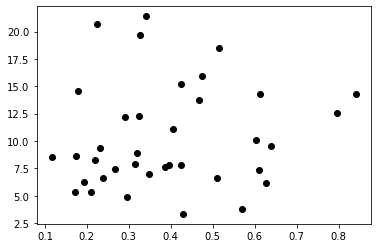

In [175]:
x = passed_trades['CBI']
y = passed_trades['Price_Delta'].values
plt.plot(x,y,'o', color='black')

In [177]:
print(no_data_tickers)

['APA', 'APA', 'APA', 'APA', 'APA', 'APA', 'APA', 'APA', 'APA', 'APA', 'APA', 'APA', 'APA', 'BKR', 'BKR', 'BKR', 'BKR', 'BKR', 'BKR', 'BKR', 'BKR', 'BKR', 'BKR', 'BKR', 'BKR', 'COG', 'COG', 'COG', 'COG', 'COG', 'COG', 'COG', 'COG', 'COG', 'COG', 'COG', 'COG', 'COG', 'COG', 'COG', 'COG', 'COG', 'COG', 'COG', 'CVX', 'CVX', 'CVX', 'CVX', 'CVX', 'CVX', 'CVX', 'CVX', 'CVX', 'CVX', 'CVX', 'CVX', 'CVX', 'CVX', 'COP', 'COP', 'COP', 'COP', 'COP', 'COP', 'COP', 'COP', 'COP', 'COP', 'COP', 'COP', 'COP', 'COP', 'COP', 'COP', 'DVN', 'DVN', 'DVN', 'DVN', 'DVN', 'DVN', 'DVN', 'DVN', 'DVN', 'DVN', 'DVN', 'DVN', 'DVN', 'DVN', 'DVN', 'DVN', 'FANG', 'FANG', 'FANG', 'FANG', 'FANG', 'FANG', 'FANG', 'FANG', 'FANG', 'FANG', 'FANG', 'FANG', 'FANG', 'FANG', 'FANG', 'FANG', 'FANG', 'FANG', 'FANG', 'EOG', 'EOG', 'EOG', 'EOG', 'EOG', 'EOG', 'EOG', 'EOG', 'EOG', 'EOG', 'EOG', 'EOG', 'EOG', 'EOG', 'EOG', 'EOG', 'XOM', 'XOM', 'XOM', 'XOM', 'XOM', 'XOM', 'XOM', 'XOM', 'XOM', 'XOM', 'XOM', 'XOM', 'XOM', 'XOM', 'XOM', 